In [ ]:
#1. Importo librerías.
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import os
import time
import random
from dateutil import parser
import matplotlib.pyplot as plt

In [95]:
#2. Leo datasets.
clarin = pd.read_parquet("../clarin/outputs/noticias_clarin.parquet")
pagina12 = pd.read_parquet("../pagina12/outputs/noticias_pagina12.parquet")
ambito = pd.read_parquet("../ambito/noticias_ambito.parquet")
lanacion = pd.read_parquet("../lanacion/noticias_LN_2025Q1.parquet")

In [96]:
#3. Homogeinizo nombres y columnas entre los datasets.
#a. Ámbito.
ambito["diario"] = "Ámbito Financiero"
ambito.rename({"articulo":"contenido"},axis=1,inplace=True)
ambito['fecha'] = pd.to_datetime(ambito['fecha'])
del ambito["resumen"]
#b. Clarín
clarin.rename({"titulo noticia":"titulo","link":"url"},axis=1,inplace=True)
clarin["seccion"] = "economia"
#c. Página 12.
pagina12.rename({"titulo noticia":"titulo","link":"url"},axis=1,inplace=True)
pagina12["seccion"] = "economia"
#d. La Nación.
lanacion["diario"] = "La Nación"
lanacion.rename({"fecha_publicacion":"fecha","texto":"contenido"},axis=1,inplace=True)
lanacion.drop(columns=["id", "status","bajada"],inplace=True)

In [97]:
#4. Homogeinizo tipo de datos en las fechas.
#a. La Nación.
def solo_fecha(f):
    try:
        return parser.isoparse(f).date()
    except Exception:
        return pd.NaT
lanacion['fecha'] = lanacion['fecha'].apply(solo_fecha)
lanacion['fecha'] = pd.to_datetime(lanacion['fecha'], errors='coerce').dt.normalize()
#b. Ámbito.
ambito['fecha'] = pd.to_datetime(ambito['fecha'], errors='coerce').dt.normalize()

In [98]:
#5. Ordeno todas de menor a mayor, y verifico que no tenga noticias de otras fechas.
#a. Defino rango de fechas que vamos a considerar.
fecha_inicio = pd.to_datetime("2025-01-01")
fecha_fin = pd.to_datetime("2025-04-30")

#b. Lista de DataFrames a corregir.
diarios = [ambito, clarin, lanacion, pagina12]

#c. Función para filtrar el entrefechas de análisis.
def preparar_df(df):
    #i. Ordeno por fecha ascendente.
    df = df.sort_values(by='fecha', ascending=True)
    #ii. Filtro por el rango de fechas.
    df = df[(df['fecha'] >= fecha_inicio) & (df['fecha'] <= fecha_fin)]
    return df

#d. Aplico a cada diario la correción sobre las fechas.
ambito = preparar_df(ambito)
clarin = preparar_df(clarin)
lanacion = preparar_df(lanacion)
pagina12 = preparar_df(pagina12)

In [99]:
#6. Verifico que coincidan las columnas entre todos.
#a. Columnas esperadas.
orden_columnas = clarin.columns

#b. Lista de DataFrames con nombres.
diarios = {
    'ambito': ambito,
    'clarin': clarin,
    'lanacion': lanacion,
    'pagina12': pagina12
}

#c. Verifico columnas.
for nombre, df in diarios.items():
    faltantes = [col for col in orden_columnas if col not in df.columns]
    extras = [col for col in df.columns if col not in orden_columnas]
    print(f"{nombre}:")
    if faltantes:
        print(f"  ❌ Faltan columnas: {faltantes}")
    else:
        print("  ✅ Todas las columnas esperadas están presentes")
    if extras:
        print(f"  ⚠️ Columnas adicionales: {extras}")
    print()


ambito:
  ✅ Todas las columnas esperadas están presentes

clarin:
  ✅ Todas las columnas esperadas están presentes

lanacion:
  ✅ Todas las columnas esperadas están presentes

pagina12:
  ✅ Todas las columnas esperadas están presentes



In [100]:
#7. Homogeinizo el orden de las columnas.
#a. Función para reordenar y agregar columnas faltantes.
def uniformizar_columnas(df, columnas_objetivo):
    #i. Agrego columnas faltantes.
    for col in columnas_objetivo:
        if col not in df.columns:
            df[col] = pd.NA
    #ii. Reordeno columnas.
    return df[columnas_objetivo]

#b. Aplico a cada DataFrame.
for nombre in diarios:
    diarios[nombre] = uniformizar_columnas(diarios[nombre], orden_columnas)

#c. Almaceno
ambito = diarios['ambito']
clarin = diarios['clarin']
lanacion = diarios['lanacion']
pagina12 = diarios['pagina12']

In [110]:
#8. Concateno todos los dataframes en uno solo.
#a. Lista de DataFrames.
dfs = [ambito, clarin, lanacion, pagina12]
#b. Concateno en un solo DataFrame.
df = pd.concat(dfs, ignore_index=True).reset_index(drop=True)

In [112]:
#9. Exportación.
df.to_parquet("./df.parquet")

In [ ]:
#10. Estadísticas básicas.
#a. Noticias totales.
print("El total de noticias es: {}".format(df.shape[0]))

El total de noticias es: 15244


In [ ]:
#b. Noticias totales aperturado por diario.
df["diario"].value_counts().sort_values(ascending=False)

diario
La Nación            6968
Ámbito Financiero    4623
Clarín               2674
Pagina 12             979
Name: count, dtype: int64

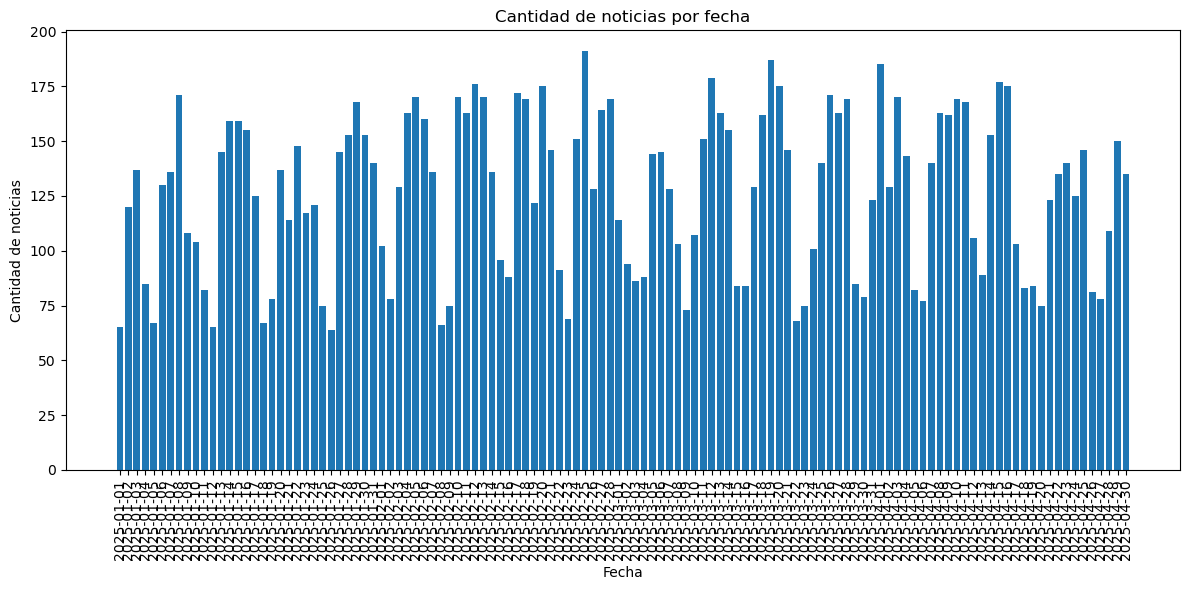

In [ ]:
#c. Noticias totales aperturado por fecha.
#i. Contamos ocurrencias por fecha.
conteo_fechas = df['fecha'].value_counts().sort_index()
#ii. Graficamos.
plt.figure(figsize=(12,6))
plt.bar(conteo_fechas.index.astype(str), conteo_fechas.values)
plt.xticks(rotation=90)
plt.xlabel("Fecha")
plt.ylabel("Cantidad de noticias")
plt.title("Cantidad de noticias por fecha")
plt.tight_layout()
plt.show()


In [ ]:
#d. Noticias por Sección.
df["seccion"].value_counts().sort_values(ascending=False)

seccion
economia             5117
Política             2612
Economía             2081
politica             1568
finanzas             1464
Campo                 884
Futuria               564
Dólar Hoy             313
opinion               289
Negocios              255
Agricultura            22
Ganadería              18
Comercio Exterior      16
Tecnologías            10
Regionales              9
El Mundo                5
undefined               4
Sociedad                4
Autos                   4
Tecnología              3
Propiedades             1
LN+                     1
Name: count, dtype: int64